# Exploratory Data Analysis of the **CBIS-DDSM** Dataset

## CBIS-DDSM Dataset

Developed in 1997 through a grant from the DOD Breast Cancer Research Program and the US Army Research and Material Command, the *original* Digital Database for Screening Mammography (DDSM) {cite}`USFDigitalMammography` is a collection of 2620 cases obtained by patient consent from Massachusetts General Hospital, Wake Forest University School of Medicine, Sacred Heart Hospital, and Washington University of St. Louis School of Medicine. Its cases are annotated with ROIs for calcifications and masses, they include Breast Imaging Reporting and Data System (BI-RADS) descriptors for mass shape, mass margin, calcification type, calcification distribution, and breast density. They also include overall BI-RADS assessments from 0 to 5 and ratings of the subtlety of the abnormalities from 1 to 5.

The DDSM, a powerful and extensively used resource for imaging research, presented certain challenges that limited its accessibility and utility.  For instance, the original DDSM was saved in lossless JPEG files (LJPEG); a non-standard, and obsolete compression format. Regions of interest marked the general area of legions; but, lacked the specificity of precise image segmentation, requiring researchers to implement segmentation algorithms for accurate feature extraction. Some annotations marked legions that could not be seen. Further, the metadata processing and image correction routines distributed with the dataset were a set of bash and C routines that were difficult to refactor.
This Curated Breast Imaging Subset of DDSM (CBIS-DDSM) {cite}`leeCuratedMammographyData2017` is an updated and standardized version of the original DDSM, developed to address some of the challenges. In particular, the questionable annotations were reviewed by a trained mammographer, and 254 images were removed from the dataset. The images were converted from PVRG-JPEG to 8-bit raw binary bitmaps. Python tools were developed to convert the 8-bit images to 16-bit grayscale TIFF files, which were later converted to DICOM. The bash and C preprocessing tools were re-implemented in Python to be cross-platform. Convenience images were cropped around the region of interest for researchers analyzing only the abnormalities. Precise segmentation was applied to the calcification images providing much more accurate regions of interest, and the data were split into training and test sets, based on the BIRADS category to support method evaluation and reproducibility.

### Dataset Statistics

CBIS-DDSM was obtained from the Cancer Imaging Archive {cite}`sawyer-leeCuratedBreastImaging2016` and is summarized below:

```{table}

| Collection Statistics  |        |
| ---------------------- | ------ |
| Image Size (GB)        | 163.6  |
| Modalities             | MG     |
| Number of Images       | 10239  |
| Number of Participants | 1,566  |
| Number of Series       | 6775   |
| Number of Studies      | 6775   |
```

The CBIS-DDSM data were split into training and test (20%), sets based on BI-RADS category. Splitting by abnormality type, 20% of the cases were allocated to the test sets and the remaining were designated for training.

```{table}

| Dataset                    | Benign Cases                  | Malignant Cases               |
|----------------------------|-------------------------------|-------------------------------|
| Calcification Training Set | 329 Cases (552 Abnormalities) | 273 Cases (304 Abnormalities) |
| Calcification Test Set     | 85 Cases (112 Abnormalities)  | 66 Cases (77 Abnormalities)   |
| Mass Training Set          | 355 Cases (387 Abnormalities) | 336 Cases (361 Abnormalities) |
| Mass Test Set              | 117 Cases (135 Abnormalities) | 83 Cases (87 Abnormalities)   |
```

### Dataset Organization

The following files contain the mammography and ROIs for the cases with calcifications.

```{table}

| Type   | Filename                             | Format |
| ------ | ------------------------------------ | ------ |
| Images | Calc-Test Full Mammogram Images      | DICOM  |
| Images | Calc-Test ROI and Cropped Images     | DICOM  |
| Images | Calc-Training Full Mammogram Images  | DICOM  |
| Images | Calc-Training ROI and Cropped Images | DICOM  |
```

The following files contain the mammography and ROIs for the mass cases.

```{table}


| Type   | Filename                             | Format |
| ------ | ------------------------------------ | ------ |
| Images | Mass-Test Full Mammogram Images      | DICOM  |
| Images | Mass-Test ROI and Cropped Images     | DICOM  |
| Images | Mass-Training Full Mammogram Images  | DICOM  |
| Images | Mass-Training ROI and Cropped Images | DICOM  |
```

There are separate metadata files for the train and test calcification and mass cases.

```{table}


| Type     | Filename                  | Format |
| -------- | ------------------------- | ------ |
| Metadata | Calc-Test-Description     | csv    |
| Metadata | Calc-Training-Description | csv    |
| Metadata | Mass-Test-Description     | csv    |
| Metadata | Mass-Training-Description | csv    |
```

Metadata for each abnormality above contains:

- Patient ID: the first 7 characters of images in the case file*
- Density category
- Breast: Left or Right
- View: CC or MLO
- Number of abnormality for the image (This is necessary as there are some cases containing multiple abnormalities.)
- Mass shape (when applicable)
- Mass margin (when applicable)
- Calcification type (when applicable)
- Calcification distribution (when applicable)
- BI-RADS assessment
- Pathology: Benign, Benign without call-back, or Malignant
- Subtlety rating: Radiologists’ rating of difficulty in viewing the abnormality in the image
- Path to image files

Note, the data are structured such that a single participant has multiple patient IDs in the DICOM Metadata.

In [1]:
import sys
import os
os.chdir(os.path.abspath(os.path.join("../..")))
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from PIL import Image
from bcd.data.dataset import CBISMeta
sns.set_style('whitegrid')
sns.set_palette("Blues_r")

## Exploratory Data Analysis Plan

Here, we'll put forward a set of questions and an approach to guide the analysis and discovery.

### Exploratory and Guiding Questions

> “Far better an approximate answer to the right question, which is often vague, than an exact answer to the wrong question,
> which can always be made precise.” — John Tukey

We'll begin our exploration with questions to guide the process.

1. Density is considered a potential signal of pathology. How does density relate to pathology in the CBIS-DDSM dataset?
2. Does density and abnormality type relate?
3. What does density and abnormality type indicate w.r.t pathology?
4. Which abnormality type is most malignant in the dataset?
5. Which abnormality type is more subtle?

Regarding Calcifications:

1. What does density, calcification type and distribution imply about subtlety, and pathology?
2. How does calcification type relate to subtlety? pathology?
3. What does calcification distribution relate to subtlety, pathology?

For masses:

1. What does density, mass shape and margin imply about subtlety, and pathology?
2. What does density and calcification type and distribution imply about subtlety, and pathology?
3. How does mass shape relate to subtlety? pathology?
4. How does mass margin relate to subtlety? pathology?

### Exploratory Approach

Our approach will include metadata and images for both train/test splits. To avoid bias during modeling, all feature engineering and data processing will be performed *after* data splitting, with one exception. There are three pathologies for our binary classification task ['MALIGNANT','BENIGN', 'BENIGN_WITHOUT_CALLBACK']. For this analysis we will add a new binary variable, 'cancer' in which a value of 0 means benign and a value of 1 indicates malignancy. We'll decide what to do about these variables for modeling during the feature engineering stage.

Hence, we shall proceed as follows:

1. Whole Dataset Analysis using the combined metadata datasets. Features analyzed will be the intersection of calcification and mass dataset features.
2. Calcification Case Analysis using the combined calcifiation set.
3. Mass Case Analysis using the combined mass set.

## EDA Stage 1: Cross-Dataset Analysis

This initial stage focuses on the variables in common between the training sets.

In [2]:
# Filepaths
fpc1 = "/home/john/projects/bcd/data/raw/meta/calc_case_description_train_set.csv"
fpc2 = "/home/john/projects/bcd/data/raw/meta/calc_case_description_test_set.csv"
fpm1 = "/home/john/projects/bcd/data/raw/meta/mass_case_description_train_set.csv"
fpm2 = "/home/john/projects/bcd/data/raw/meta/mass_case_description_test_set.csv"

In [3]:
## Dataframes
dfc1 = pd.read_csv(fpc1)
dfc2 = pd.read_csv(fpc2)
dfm1 = pd.read_csv(fpm1)
dfm2 = pd.read_csv(fpm2)
# Rename breast density column
dfm1.rename(columns={'breast_density': 'breast density'}, inplace=True)
dfm2.rename(columns={'breast_density': 'breast density'}, inplace=True)
# Add 'cancer' variable
dfc1['cancer'] = np.where(dfc1['pathology'] == 'MALIGNANT', 1, 0)
dfc2['cancer'] = np.where(dfc2['pathology'] == 'MALIGNANT', 1, 0)
dfm1['cancer'] = np.where(dfm1['pathology'] == 'MALIGNANT', 1, 0)
dfm2['cancer'] = np.where(dfm2['pathology'] == 'MALIGNANT', 1, 0)
## DataFrames by Abnormality Type
dfc = pd.concat([dfc1,dfc2], axis=0)
dfm = pd.concat([dfm1,dfm2], axis=0)
# Whole DataFrames
df1 = dfc.drop(columns=['calc type', 'calc distribution'])
df2 = dfm.drop(columns=['mass shape', 'mass margins'])
df = pd.concat([df1,df2], axis=0)
# CBIS Datasets
ds = CBISMeta(df=df)  # Whole dataset
dsc = CBISMeta(df=dfc)  # Calcification Dataset
dsm = CBISMeta(df=dfm)  # Mass Dataset

In [4]:
ds.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,cancer
0,P_00005,3,RIGHT,CC,1,calcification,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,1
1,P_00005,3,RIGHT,MLO,1,calcification,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,1
2,P_00007,4,LEFT,CC,1,calcification,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,0
3,P_00007,4,LEFT,MLO,1,calcification,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,0
4,P_00008,1,LEFT,CC,1,calcification,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,0


In [5]:
ds.info

,Column,DataType,Valid,Null,Validity,Cardinality,Percent Unique,Size
0,patient_id,object,3568,0,1.00,1566,0.44,228352
1,breast density,int64,3568,0,1.00,5,0.00,28544
2,left or right breast,object,3568,0,1.00,2,0.00,219397
3,image view,object,3568,0,1.00,2,0.00,212408
4,abnormality id,int64,3568,0,1.00,7,0.00,28544
5,abnormality type,object,3568,0,1.00,2,0.00,234496
6,assessment,int64,3568,0,1.00,6,0.00,28544
7,pathology,object,3568,0,1.00,3,0.00,240749
8,subtlety,int64,3568,0,1.00,6,0.00,28544
9,image file path,object,3568,0,1.00,3103,0.87,809040


**Initial observations:**

1. There are 3568 cases of abnormality seen on the craniocaudal (CC) and/or mediolateral oblique (MLO) views.
2. We have 1566 patient_ids corresponding to each of the 1566 subjects in the studies.
3. Breast density should have a cardinality of 4, not 5.
4. There are 7 BIRADS assessment categories, yet 6 are indicated in the CBIS-DDSM. One would suspect values of [0,5] as a 6 would mean cancer was previously diagnosed using a biopsy.
5. As indicated our binary classification actually has three pathologies ['MALIGNANT', 'BENIGN', and 'BENIGN_WITHOUT_CALLBACK']. We've added the cancer variable to capture the presence of malignancy in the assessment.
6. There are 465 duplicate image filepaths, indicating several cases on an image.

### Univariate Analysis

#### Patient Id

In [6]:
print(f"The total number of patient unique ids {df['patient_id'].nunique()}, corresponding to the number of subjects in the studies.")
print(f"The median number of images per patient id is {df['patient_id'].value_counts().median()}")
print(f"The average number of images per patient id is {round(df['patient_id'].value_counts().mean(),2)}")
print(f"The range of images to patient_ids is {df['patient_id'].value_counts().min()} to {df['patient_id'].value_counts().max()} ")

The total number of patient unique ids 1566, corresponding to the number of subjects in the studies.
The median number of images per patient id is 2.0
The average number of images per patient id is 2.28
The range of images to patient_ids is 1 to 24 


#### Breast Density

Radiologists classify breast density using a 4-level density scale {cite}`BreastImagingReporting`:

1. Almost entirely fatty
2. Scattered areas of fibroglandular density
3. Heterogeneously dense
4. Extremely dense

According to the American College of Radiology™️, breast density in the U.S.:

- 10% of women have almost entirely fatty breasts,
- 10% have extremely dense breasts,
- 40% of women have scattered areas of fibroglandular density
- 40% have heterogeneously dense breasts

In [7]:
d1 = np.repeat([1], 357)
d2 = np.repeat([2], 1427)
d3 = np.repeat([3], 1427)
d4 = np.repeat([4], 357)
d = np.append(arr=d1,values=d2)
d = np.append(arr=d,values=d3)
d = np.append(arr=d,values=d4)
d = {"Breast Density": d, "Sample": "U.S."}
usd = pd.DataFrame(data=d)
density = df['breast density'].to_frame()
density.rename(columns={'breast density': 'Breast Density'}, inplace=True)
density['Sample'] = 'CBIS-DDSM'
density = pd.concat([density, usd], axis=0).reset_index()

The following exhibits the counts by density in the CBIS-DDSM dataset vis-a-vis a sample from the US of the same size.

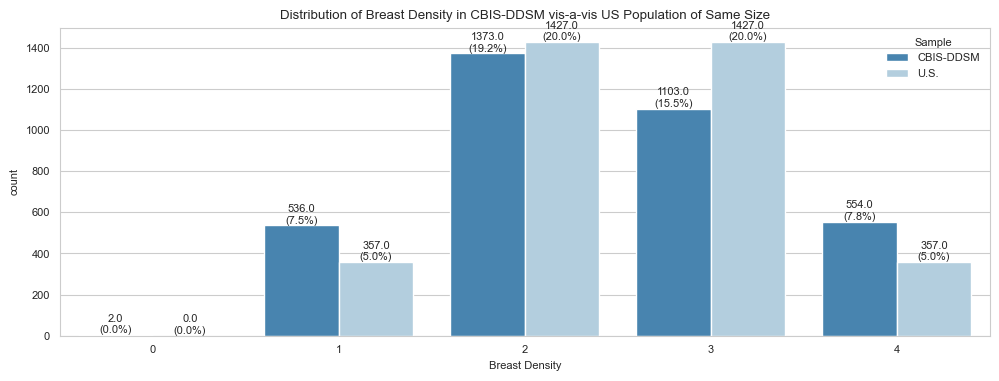

In [8]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(data=density,x='Breast Density', hue="Sample", ax=ax, title ="Distribution of Breast Density in CBIS-DDSM vis-a-vis US Population of Same Size")

If we were to perform a goodness of fit test on the two samples, the null hypothesis of breast density in CBIS-DDSM and breast density in the US Population originating from the same distribution, would likely be rejected. The CBIS-DDSM has fatter tails on both ends of the distribution. Some right skew is extant as well.

#### Left Right

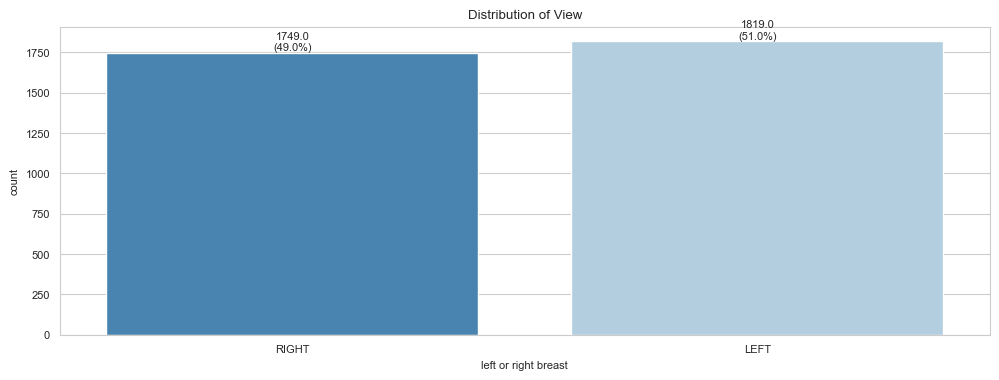

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='left or right breast', ax=ax, title ="Distribution of View")

There are slightly more left views than right; still, the dataset is fairly balanced in this regard for what that's worth.

#### Image View

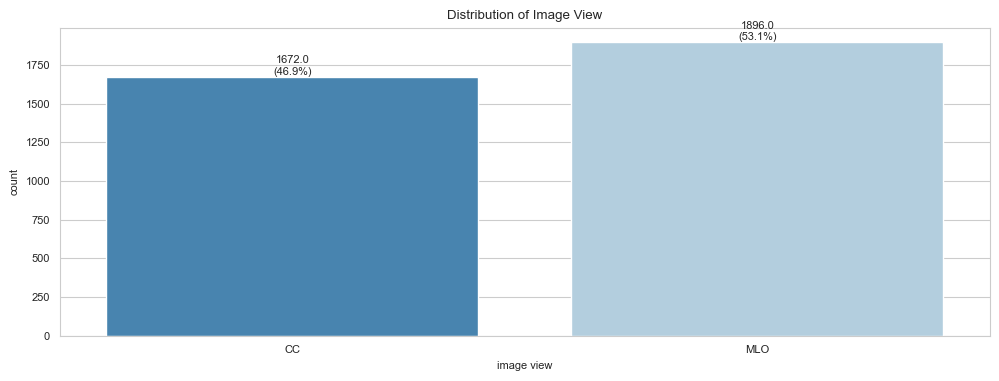

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='image view', ax=ax, title ="Distribution of Image View")

Mediolateral oblique views slightly outnumber craniocaudal views.

#### Abnormality Id

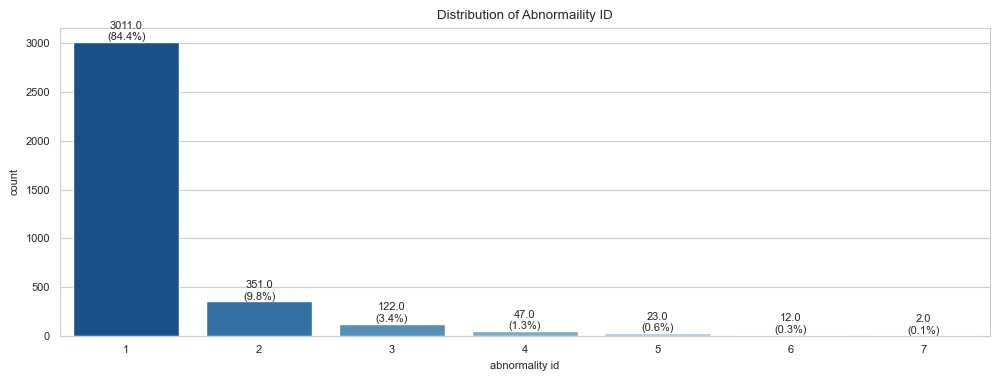

In [11]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='abnormality id', ax=ax, title ="Distribution of Abnormaility ID")

A plurality of patients present only one abnormality.

#### Calcification Type

ValueError: Could not interpret input 'calc type'

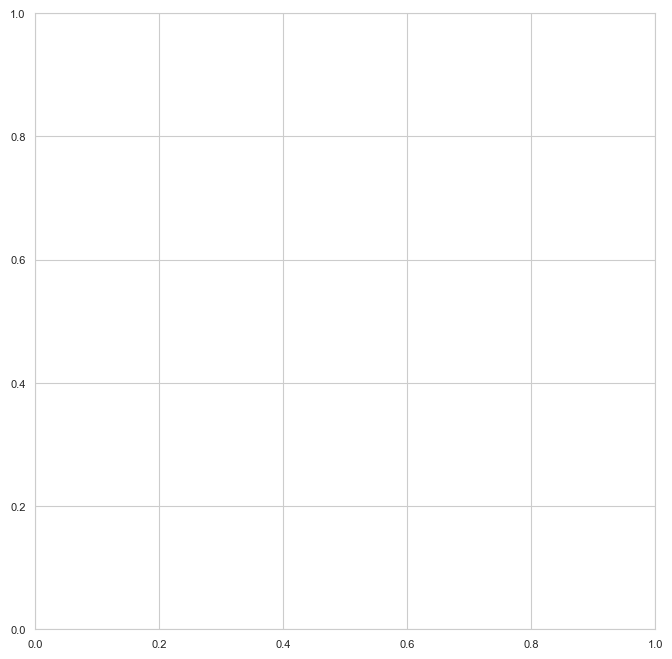

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
ds.plot.countplot(y='calc type', ax=ax, title ="Distribution of Calcification Type")

#### Calcification Distribution

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(y='calc distribution', ax=ax, title ="Calcification Distribution")

#### BIRADS Assessment

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='assessment', ax=ax, title ="Distribution of BIRADS Assessment")

#### Pathology

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='pathology', ax=ax, title ="Distribution of Pathology")

#### Sublety

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='subtlety', ax=ax, title ="Distribution of Subtlety")

### Bivariate Analysis

At this stage, we are examining bivariate relationships between the variables and between the variables and the target, pathology.

#### Density Analysis

Here, we'll explore how breast density relates to pathology, calcification type and distribution, assessment, and subtlety.

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='breast density', hue='pathology'   , ax=ax, title ="Breast Density and Pathology")

In [ ]:
ds.describe(x=['breast density', 'pathology'], groupby='breast density').categorical

**Key Observations**

1. Lower density abnormalities were associated with a greater number of benign, without callback. This is not unexpected as greater density is typically associated with greater scrutiny.
2. Level 2 density typically indicates scattered areas of fibroglandular density, but the majority of tissue is non-dense. In this level 2 (or B), the vast majority of cases were benign, but the proportion of malignant cases appears to be increasing.
3. Level 3 density typically indicates some areas of nondense tissue, but most areas are dense. Here too, the majority of cases were benign; however, the proportion of malignant cases increased from level 2.
4. In contrast to level 1 density, there are fewer benign without callback cases. This indicates a greater degree of suspicion with these patients.